In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt
ds = load_dataset("tanganke/stanford_cars") 

train_data= ds["train"]
test_data = ds["test"] 

Image dimension: (640, 480)


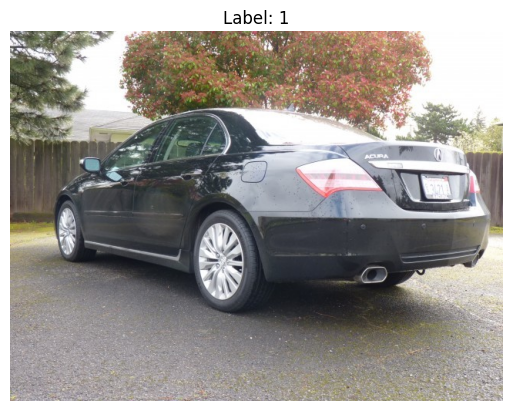

In [6]:
# Display the first image
img = train_data[51]["image"]
label = train_data[51]["label"]
print(f"Image dimension: {img.size}")

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()


Image dimension: (700, 525)


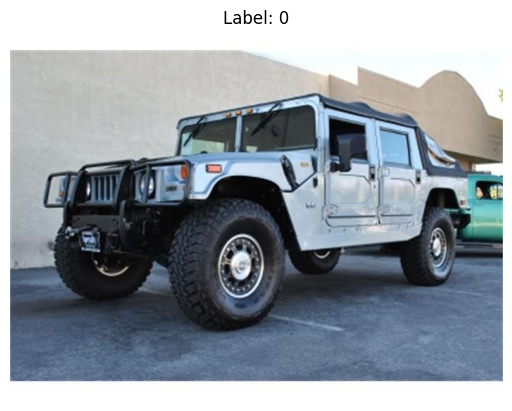

In [8]:
img = train_data[0]["image"]
label = train_data[0]["label"]
print(f"Image dimension: {img.size}")

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Image dimension: (305, 203)


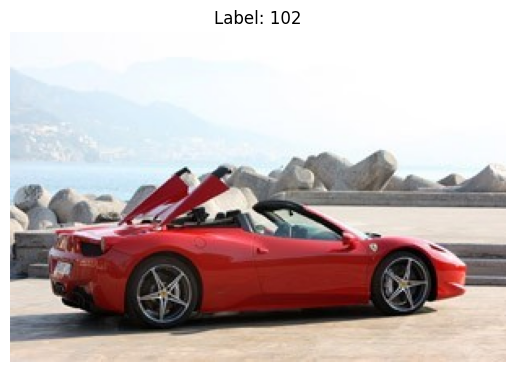

In [9]:
img = train_data[220]["image"]
label = train_data[220]["label"]
print(f"Image dimension: {img.size}")

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

Image dimension: (300, 225)


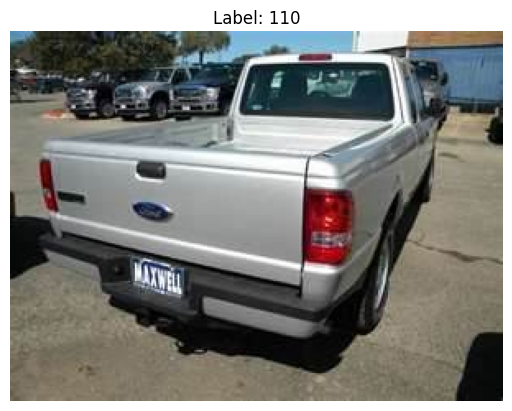

In [10]:
img = train_data[598]["image"]
label = train_data[598]["label"]
print(f"Image dimension: {img.size}")

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

__Visualize the correct sample predictions of the model__

In [1]:
from car_detector.data_process import denormalize
import matplotlib.pyplot as plt 
import pickle 

with open(f"/Users/xiang/Desktop/Car-Brand-Detector/car_detector/results/correct_samples/366 ResNet Success Samples.pkl", "rb") as f:
    data= pickle.load(f)

/opt/anaconda3/envs/cv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


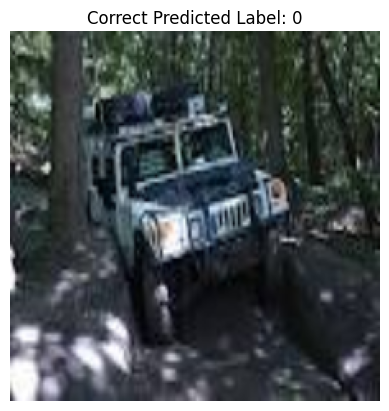

In [15]:
sample= data[0]
img= sample[0] 
label= sample[1] 

img_denorm = denormalize(img)

# Convert from [C,H,W] -> [H,W,C] for matplotlib
plt.imshow(img_denorm.permute(1, 2, 0).numpy())

plt.title(f"Correct Predicted Label: {label}")
plt.axis("off")
plt.show()

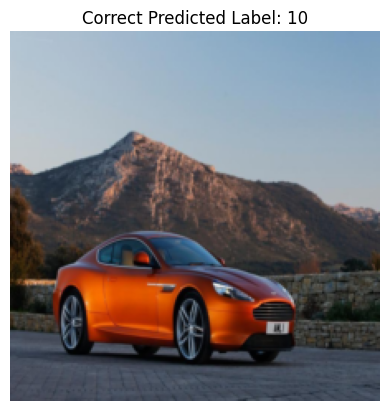

In [16]:
sample= data[10]
img= sample[0] 
label= sample[1] 

img_denorm = denormalize(img)

# Convert from [C,H,W] -> [H,W,C] for matplotlib
plt.imshow(img_denorm.permute(1, 2, 0).numpy())

plt.title(f"Correct Predicted Label: {label}")
plt.axis("off")
plt.show()

__Visualize the incorrect sample predictions of the model__

In [17]:
with open(f"/Users/xiang/Desktop/Car-Brand-Detector/car_detector/results/incorrect_samples/359 ResNet Fail Samples.pkl", "rb") as f:
    data= pickle.load(f)

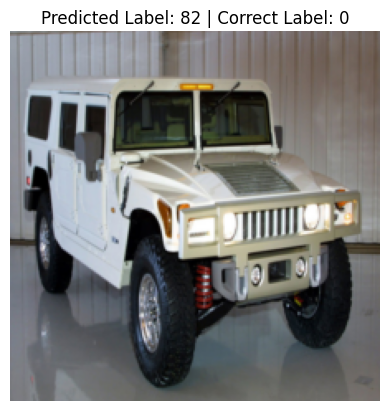

In [18]:
sample= data[0]
img= sample[0] 
label= sample[1] 
correct = sample[2]

img_denorm = denormalize(img)

# Convert from [C,H,W] -> [H,W,C] for matplotlib
plt.imshow(img_denorm.permute(1, 2, 0).numpy())

plt.title(f"Predicted Label: {label} | Correct Label: {correct}")
plt.axis("off")
plt.show()

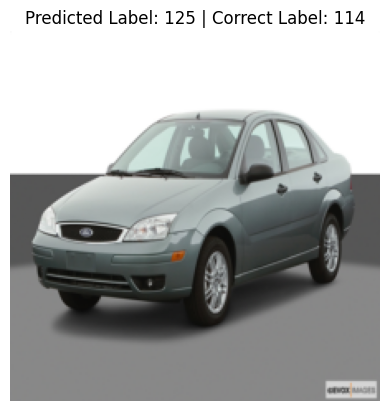

In [19]:
sample= data[31]
img= sample[0] 
label= sample[1] 
correct = sample[2]

img_denorm = denormalize(img)

# Convert from [C,H,W] -> [H,W,C] for matplotlib
plt.imshow(img_denorm.permute(1, 2, 0).numpy())

plt.title(f"Predicted Label: {label} | Correct Label: {correct}")
plt.axis("off")
plt.show()

### Visualize the heatmap of model layer to add explainability to the model 

In [38]:
import matplotlib.pyplot as plt
from torchvision import models as torch_models 
from car_detector.grad_cam import GradCAM 
import numpy as np
import torch.nn as nn 
import torch 
from PIL import Image

def overlay_heatmap(img_pil, cam_tensor, alpha=0.35):
    """cam_tensor: (H,W) in [0,1]"""

    # assume img_pil is a PIL Image 
    import cv2
    cam_np = cam_tensor.cpu().numpy()
    cam_u8 = (cam_np * 255).astype(np.uint8)

    base = img_pil.convert("RGB")
    size = (base.width, base.height)

    hm = cv2.applyColorMap(cam_u8, cv2.COLORMAP_JET)[:, :, ::-1]  # BGR->RGB

    # Blend
    hm = Image.fromarray(hm).resize(size, Image.BILINEAR)  # or Image.Resampling.BILINEAR on newer Pillow
    return Image.blend(base, hm, alpha)

In [3]:
# establish the code 
model= torch_models.vgg16(weights=torch_models.VGG16_Weights.IMAGENET1K_V1) 
model.classifier[6]=nn.Linear(4096, 196)

ckpt= torch.load("/Users/xiang/Desktop/Car-Brand-Detector/car_detector/model_ckpt/2 Epoch vgg16.ckpt")
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [4]:
# load the last target layer 
target_layer= model.features[28] 
print(target_layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [5]:
# change the ReLU to be back in-place 
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

In [6]:
# create Grad CAM classes 
cam_extractor= GradCAM(model=model, target_layer=target_layer)

In [23]:
# get the image data 
sample= data[10]
img= sample[0] 
label= sample[1]

# denormalize the img 
img= denormalize(img=img)

# reshape to have batch size 
img= img.reshape(1,3,224,224)

In [24]:
# complete activation map extract 
with torch.enable_grad():  # we need grad, so don't use torch.no_grad
    cam, pred_idx = cam_extractor(img, class_idx=None)

In [28]:
print(img.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
# convert image Tensor to a PIL Image 
import torchvision.transforms.functional as TF

# reshape to get rid of batch 
img=img.squeeze(0)

# convert tensor into PIL Image 
pil_img = TF.to_pil_image(img)

In [ ]:
# make into an image 
blended = overlay_heatmap(pil_img, cam[0])

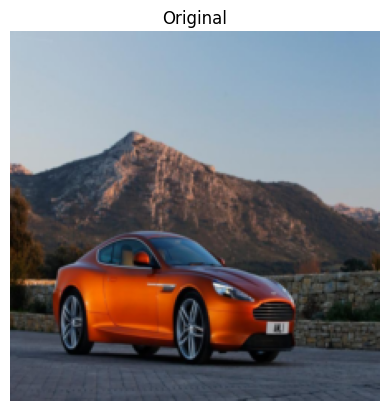

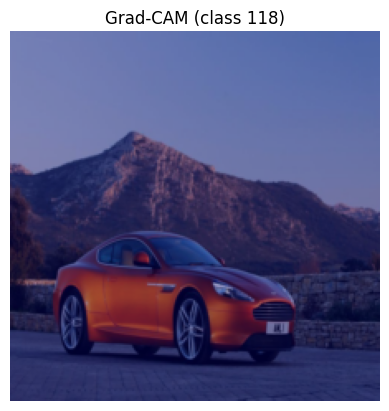

In [40]:
plt.figure(); plt.imshow(pil_img); plt.axis("off"); plt.title("Original")
plt.figure(); plt.imshow(blended); plt.axis("off"); plt.title(f"Grad-CAM (class {pred_idx.item()})")
plt.show()